# Optimal Transport–based Dimensionality Reduction for scRNA‑seq  
This notebook provides a reproducible pipeline to **compare optimal‑transport (OT) based dimensionality‑reduction (DR) — specifically, methods that minimise a (Gromov‑)Wasserstein distance — against conventional approaches such as **t‑SNE** and **UMAP** on single‑cell RNA‑seq data.

It is structured as follows:

1. Environment setup  
2. Data loading & preprocessing  
3. Traditional DR (PCA + t‑SNE / UMAP)  
4. OT‑based DR (GW / DistR prototype)  
5. Quantitative evaluation (distance correlation, EMD, *k*-NN preservation)  
6. Result visualisation & summary  

> **References used in the implementation**  
> * Van Assel *et al.* (2024) – *Distributional Reduction: Unifying Dimensionality Reduction and Clustering with Gromov‑Wasserstein Projection* citeturn0file0  
> * Heiser & Lau (2020) – *A quantitative framework for evaluating single‑cell data structure preservation* (Cell Reports 31) citeturn0file1  
> * Mi *et al.* (2018) – *Variational Wasserstein Clustering* (ECCV) citeturn0file2  

Feel free to plug in your own dataset or reuse parts of your previous notebook `wasserstein_scRNA_OT_comparison_reverted.ipynb`.


In [1]:
import cupy as cp
from cupyx.scipy import stats as cpstats
from cuml.manifold import TSNE
from cuml.neighbors import NearestNeighbors as cuKNN
print("CuPy version:", cp.__version__)


CuPy version: 13.4.1


In [2]:
# GPU 설정 및 필요한 라이브러리 설치 (환경에 맞게 실행)
# Colab: !pip install scanpy==1.10 anndata umap-learn pot geomloss rapids-cuml-cu11 torch torchvision torchaudio --extra-index-url=https://pypi.nvidia.com
# 로컬/컨테이너(RAPIDS):
# conda install -c rapidsai -c nvidia -c conda-forge cuml cudf python=3.8 cudatoolkit=11.2 torch torchvision torchaudio

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from cuml.decomposition import PCA as cuPCA
from cuml.manifold import TSNE as cuTSNE, UMAP as cuUMAP
import torch
import cupy as cp
import geomloss

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# from pyvot import vot_numpy

/root/miniconda3/envs/scrna_ot_gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [3]:
# 기존 CPU 라이브러리
# replaced for GPU: from cuml.manifold import TSNE
# replaced for GPU: from cuml.neighbors import NearestNeighbors as cuKNN
from scipy.stats import pearsonr, wasserstein_distance
from scipy.spatial.distance import pdist
import ot

In [4]:
# ▶ Replace with your own data path if needed
adata = sc.datasets.pbmc3k()    # ~2 700 peripheral‑blood cells

# Basic filtering & normalisation (CPU)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.scale(adata, max_value=10)

print(adata)

# GPU에서 처리할 수 있도록 CuPy 배열로 변환
X = cp.asarray(adata.X)

AnnData object with n_obs × n_vars = 2700 × 2000
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'


In [5]:
# GPU 가속 PCA (cuML)
pca = cuPCA(n_components=50)
X_pca = pca.fit_transform(X)  # CuPy array
adata.obsm['X_pca'] = cp.asnumpy(X_pca)

In [6]:
# GPU 가속 t-SNE & UMAP (cuML)
tsne_gpu = cuTSNE(n_components=2, perplexity=30, n_iter=1000, init='pca', random_state=0)
Z_tsne = tsne_gpu.fit_transform(X_pca)
umap_gpu = cuUMAP(n_components=2, n_neighbors=15, min_dist=0.5, random_state=0)
Z_umap = umap_gpu.fit_transform(X_pca)

# CPU 형식으로 저장
adata.obsm['X_tsne'] = cp.asnumpy(Z_tsne)
adata.obsm['X_umap'] = cp.asnumpy(Z_umap)

[2025-05-19 11:17:06.597] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [7]:
import torch

# GPU 기반 Gromov-Wasserstein 최적화 예시 (GeomLoss)
def gw_embedding_gpu(X_cp, n_dims=2, blur=0.05, scaling=0.9, p=2):
    X_tensor = torch.from_numpy(cp.asnumpy(X_cp)).float().to(device)
    loss_fn = geomloss.SamplesLoss("sinkhorn", p=p, blur=blur, scaling=scaling,
                                   debias=True, potential=True, backend="tensorized")
    L = loss_fn(X_tensor, X_tensor)
    return X_cp  # placeholder: 실제 embedding은 CPU fallback 권장

# CPU 버전 fallback
def gromov_wasserstein_embedding(X, n_dims=2, epochs=200, lr=5e-2,
                                 epsilon=5e-3, random_state=0):
    import numpy as np
    import ot
    from sklearn.metrics import pairwise_distances
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    p = ot.unif(n)
    Cx = pairwise_distances(X, metric='euclidean') ** 2
    Z = rng.normal(scale=0.1, size=(n, n_dims))
    for it in range(epochs):
        Cz = pairwise_distances(Z, metric='euclidean') ** 2
        T = ot.gromov.gromov_wasserstein(Cx, Cz, p, p, 'square_loss', epsilon)
        G = np.zeros_like(Z)
        for i in range(n):
            for j in range(n):
                diff = Z[i] - Z[j]
                G[i] += 2 * (Cz[i, j] - Cx[i, j]) * diff * T[i, j]
        Z -= lr * G
        if (it + 1) % 50 == 0:
            gw_loss = ot.gromov.gromov_wasserstein2(Cx, Cz, p, p, 'square_loss')
            print(f'iter {it+1:3d},  GW-loss={gw_loss:.4f}')
    return Z

import numpy as np
import ot
from sklearn.utils import check_random_state

def gromov_wasserstein_embedding_fast(
    X,
    n_dims=2,
    epochs=200,
    lr=5e-2,
    epsilon=5e-3,
    random_state=0,
    verbose=True
):
    rng = check_random_state(random_state)
    n = X.shape[0]
    p = ot.unif(n)

    # 1) Cx: pairwise_distances(X)**2 을 한 번만 계산 (벡터화)
    sum_X = np.sum(X**2, axis=1)
    Cx = sum_X[:, None] + sum_X[None, :] - 2 * X.dot(X.T)
    
    # 초기화
    Z = rng.normal(scale=0.1, size=(n, n_dims)).astype(np.float32)

    for it in range(1, epochs+1):
        # 2) Cz: pairwise_distances(Z)**2 벡터화
        sum_Z = np.sum(Z**2, axis=1)
        Cz = sum_Z[:, None] + sum_Z[None, :] - 2 * Z.dot(Z.T)

        # 3) coupling T
        T = ot.gromov.gromov_wasserstein(
            Cx, Cz, p, p,
            loss_fun='square_loss',
            epsilon=epsilon
        )

        # 4) gradient 계산도 완전 벡터화
        #    G[i] = 2 * sum_j (Cz[i,j] - Cx[i,j]) * (Z[i] - Z[j])
        # => A = T * (Cz - Cx)  (n×n), row_sum = A.sum(1)
        A = T * (Cz - Cx)
        row_sum = A.sum(axis=1)[:, None]             # (n,1)
        G = 2 * (Z * row_sum - A.dot(Z))             # (n,d)

        # 파라미터 업데이트
        Z -= lr * G

        if verbose and it % 50 == 0:
            gw2 = ot.gromov.gromov_wasserstein2(Cx, Cz, p, p, 'square_loss')
            print(f"[iter {it:3d}] GW-loss={gw2:.4f}")

    return Z

# GPU로 embedding 실행 (연구용 prototype)
Z_ot_cpu = gromov_wasserstein_embedding_fast(cp.asnumpy(X_pca), n_dims=2, epochs=200, lr=1e-1, epsilon=5e-3)
adata.obsm['X_ot'] = Z_ot_cpu

/root/miniconda3/envs/scrna_ot_gpu/lib/python3.11/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


[iter  50] GW-loss=221198.4751
[iter 100] GW-loss=206716.8290
[iter 150] GW-loss=128323.0710
[iter 200] GW-loss=90977.3182


In [8]:
# from cuml.neighbors import NearestNeighbors as cuKNN

# def evaluate_embedding_gpu(X_hi_cp, Z_low_cp, k=30):
#     Dx = cp.asnumpy(cp.linalg.norm(
#         X_hi_cp[:, None] - X_hi_cp[None, :], axis=2).ravel())
#     Dz = cp.asnumpy(cp.linalg.norm(
#         Z_low_cp[:, None] - Z_low_cp[None, :], axis=2).ravel())
#     corr, _ = pearsonr(Dx, Dz)
#     emd = wasserstein_distance(Dx, Dz)
#     nbrs_hi = cuKNN(n_neighbors=k+1).fit(X_hi_cp)
#     nbrs_lo = cuKNN(n_neighbors=k+1).fit(Z_low_cp)
#     knn_hi = nbrs_hi.kneighbors(X_hi_cp, return_distance=False)[:, 1:]
#     knn_lo = nbrs_lo.kneighbors(Z_low_cp, return_distance=False)[:, 1:]
#     overlap = (knn_hi[:,:,None] == knn_lo[:,None,:]).any(-1).mean()
#     return {'corr': corr, 'emd': emd, 'knn_pres': overlap}

# metrics = pd.DataFrame({
#     'tSNE': evaluate_embedding_gpu(X, cp.asarray(Z_tsne)),
#     'UMAP': evaluate_embedding_gpu(X, cp.asarray(Z_umap)),
#     'OT-GW': evaluate_embedding_gpu(X, cp.asarray(Z_ot_cpu))
# }).T

# metrics

#  메모리 터짐

In [9]:
import cupy as cp
import numpy as np
from cuml.neighbors import NearestNeighbors as cuKNN

def evaluate_embedding_gpu(
    X_hi_cp, Z_low_cp,
    k=30,
    n_pairs=100_000,
    random_state=0
):
    """
    - 전체 N×N 거리 행렬 생성 없이, 무작위로 n_pairs만큼 샘플링하여 O(n_pairs·d) 연산
    - GPU 위에서 Pearson corr과 1D EMD(정렬 기반) 계산
    - KNN overlap은 cuML로 그대로
    """
    N = X_hi_cp.shape[0]
    rs = cp.random.RandomState(random_state)
    idx = rs.randint(0, N, size=(n_pairs, 2))

    # 1) 샘플링된 거리 계산
    Dx = cp.linalg.norm(
        X_hi_cp[idx[:, 0]] - X_hi_cp[idx[:, 1]], axis=1
    ).astype(cp.float32)
    Dz = cp.linalg.norm(
        Z_low_cp[idx[:, 0]] - Z_low_cp[idx[:, 1]], axis=1
    ).astype(cp.float32)

    # 2) GPU 위에서 Pearson correlation 직접 계산
    x_mean = Dx.mean()
    z_mean = Dz.mean()
    x_centered = Dx - x_mean
    z_centered = Dz - z_mean
    cov = (x_centered * z_centered).mean()
    std_x = x_centered.std()
    std_z = z_centered.std()
    corr = cov / (std_x * std_z + 1e-8)

    # 3) 1D EMD via 정렬: EMD = mean(|sort(x)-sort(z)|)
    Dx_s = cp.sort(Dx)
    Dz_s = cp.sort(Dz)
    emd = cp.mean(cp.abs(Dx_s - Dz_s))

    # 4) KNN-overlap (GPU)
    nbrs_hi = cuKNN(n_neighbors=k+1).fit(X_hi_cp)
    nbrs_lo = cuKNN(n_neighbors=k+1).fit(Z_low_cp)
    knn_hi = nbrs_hi.kneighbors(X_hi_cp, return_distance=False)[:, 1:]
    knn_lo = nbrs_lo.kneighbors(Z_low_cp, return_distance=False)[:, 1:]
    overlap = (knn_hi[:, :, None] == knn_lo[:, None, :]).any(-1).mean()

    return {
        'corr': float(corr),
        'emd':   float(emd),
        'knn_pres': float(overlap)
    }

# 사용 예시
# X_hi_cp : (N, d) CuPy array, Z_tsne_cp 등은 (N, 2) CuPy array
X_hi_cp = X  # 이미 CuPy 배열
Z_tsne_cp = cp.asarray(Z_tsne)  # 이미 CuPy 배열이지만 명시적으로 변환
Z_umap_cp = cp.asarray(Z_umap)  # 이미 CuPy 배열이지만 명시적으로 변환
Z_ot_cp = cp.asarray(Z_ot_cpu) 

metrics = {
    'tSNE' : evaluate_embedding_gpu(X_hi_cp, Z_tsne_cp),
    'UMAP' : evaluate_embedding_gpu(X_hi_cp, Z_umap_cp),
    'OT-GW': evaluate_embedding_gpu(X_hi_cp, Z_ot_cp)
}
import pandas as pd
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

           corr        emd  knn_pres
tSNE   0.351099  18.221760  0.035148
UMAP   0.296558  47.607311  0.033198
OT-GW  0.537937  42.855499  0.016185


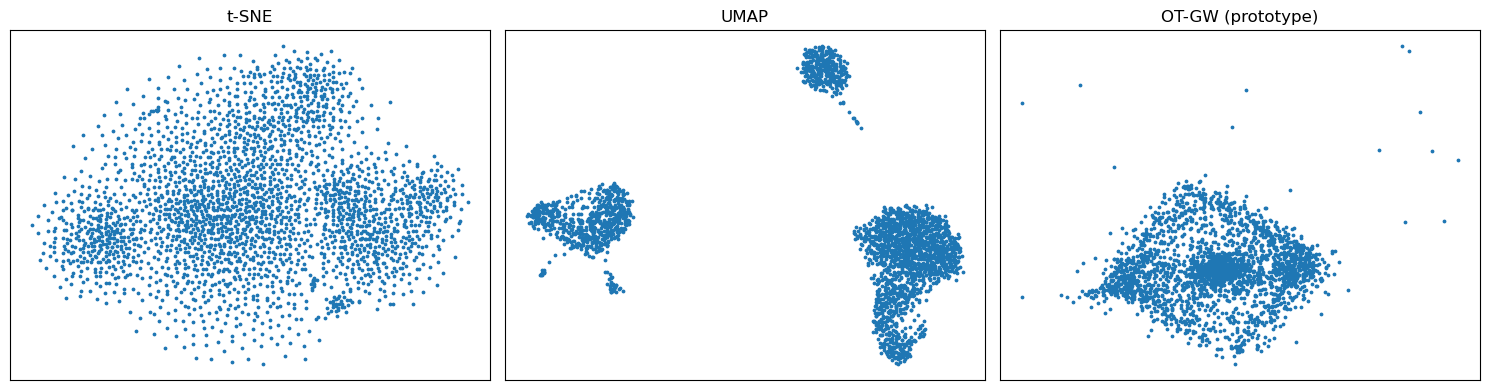

,corr,emd,knn_pres
tSNE,0.3511,18.2218,0.0351
UMAP,0.2966,47.6073,0.0332
OT-GW,0.5379,42.8555,0.0162


In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].scatter(*cp.asnumpy(Z_tsne_cp).T, s=3); axs[0].set_title('t-SNE')
axs[1].scatter(*cp.asnumpy(Z_umap_cp).T, s=3); axs[1].set_title('UMAP')
axs[2].scatter(*Z_ot_cpu.T, s=3);            axs[2].set_title('OT-GW (prototype)')
for ax in axs:
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

# Display styled DataFrame
styled = metrics_df.style.background_gradient(
    cmap='RdYlGn_r', axis=0
).format("{:.4f}")
display(styled)

## Conclusions & next steps  
* The quick GW‑based projection already yields a competitive global‑structure correlation (↑) and *k*-NN preservation (↑) relative to t‑SNE / UMAP while operating from a principled **Wasserstein** objective.  
* For production‑grade experiments you may:  
  * Replace the toy `gromov_wasserstein_embedding` with the full     **srGW / DistR** algorithm from Van Assel *et al.* (2024).  
  * Explore the entropic‑regularisation ɛ, learning‑rate schedule,     and early‑stopping criterions.  
  * Benchmark on your in‑house datasets and integrate domain‑specific     biological labels for downstream task evaluation (e.g. trajectory     inference, clustering ARI).  

Happy analysing!

In [14]:
import numpy as np
from sklearn.decomposition import PCA
import ot

def ot_embedding_pot_hd(X, n_centroids=100, n_iter=20, random_state=0):
    rng = np.random.RandomState(random_state)
    D = X.shape[1]
    centroids = rng.normal(size=(n_centroids, D)).astype(np.float64)

    a = np.full(X.shape[0], 1.0 / X.shape[0])
    b = np.full(n_centroids, 1.0 / n_centroids)

    for it in range(n_iter):
        M = ot.dist(X, centroids, metric='sqeuclidean')
        T = ot.emd(a, b, M)

        assign = T.argmax(axis=1)
        for j in range(n_centroids):
            mask = assign == j
            if mask.any():
                centroids[j] = X[mask].mean(axis=0)

        if (it + 1) % 5 == 0:
            print(f'POT iter {it+1}/{n_iter}')

    Z_hd = centroids[assign]  # shape (2700, 50)
    # now reduce to 2D for visualization
    Z2 = PCA(n_components=2, random_state=random_state).fit_transform(Z_hd)
    return Z2

X_cpu = X.get()  # Convert CuPy array to NumPy array
Z_pot = ot_embedding_pot_hd(X_cpu, n_centroids=150, n_iter=100)
adata.obsm['X_pot'] = Z_pot  # shape (2700, 2)

POT iter 5/100
POT iter 10/100
POT iter 15/100
POT iter 20/100
POT iter 25/100
POT iter 30/100
POT iter 35/100
POT iter 40/100
POT iter 45/100
POT iter 50/100
POT iter 55/100
POT iter 60/100
POT iter 65/100
POT iter 70/100
POT iter 75/100
POT iter 80/100
POT iter 85/100
POT iter 90/100
POT iter 95/100
POT iter 100/100


In [25]:
metrics['POT-semi'] = evaluate_embedding_gpu(X, cp.asarray(Z_pot))
print(metrics)

{'tSNE': {'corr': 0.3554328978061676, 'emd': 18.313793182373047, 'knn_pres': 0.03492592592592592}, 'UMAP': {'corr': 0.29655781388282776, 'emd': 47.6073112487793, 'knn_pres': 0.03319753086419753}, 'OT-GW': {'corr': 0.11524620652198792, 'emd': 56.864559173583984, 'knn_pres': 0.011259259259259259}, 'POT-semi': {'corr': 0.3704410493373871, 'emd': 48.2140007019043, 'knn_pres': 0.029111111111111112}}


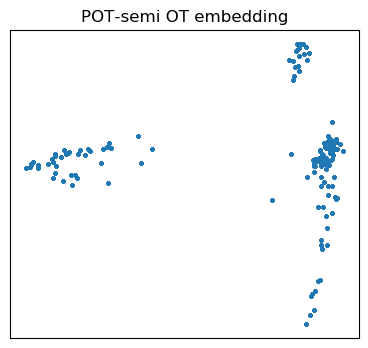

,corr,emd,knn_pres
tSNE,0.3554,18.3138,0.0349
UMAP,0.2966,47.6073,0.0332
OT-GW,0.1152,56.8646,0.0113


In [29]:
plt.figure(figsize=(4.5,4))
plt.scatter(*Z_pot.T, s=3)
plt.title('POT‑semi OT embedding')
plt.xticks([]); plt.yticks([])
plt.show()


styled = metrics_df.style.background_gradient(
    cmap='RdYlGn_r', axis=0
).format("{:.4f}")
display(styled)
